In [1]:
# This is the implementation of the EncDec-AD model based on the paper "LSTM-based Encoder-Decoder for Multi-sensor Anomaly Detection". And a slight variantion "TimeNet" based on the paper "TimeNet: Pre-trained deep recurrent neural network for time series classiﬁcation", which has been shown that achives better performance in the time series anomaly detection scenario. The only difference is the second model feeds constants to its decoder as input.

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import tensorflow as tf
from functools import reduce

# Definition of the EncDec-AD model

In [3]:
# decoder input: original time series value at last time step

class EncDecAD(object):

    def __init__(self, hidden_num, inputs, cell=None, optimizer=None, reverse=True, decode_without_input=False,):

        self.batch_num = inputs[0].get_shape().as_list()[0]
        self.elem_num = inputs[0].get_shape().as_list()[1]
        if cell is None:
            self._enc_cell = tf.nn.rnn_cell.LSTMCell(hidden_num, use_peepholes=True)
            self._dec_cell = tf.nn.rnn_cell.LSTMCell(hidden_num, use_peepholes=True)

        else:
            self._enc_cell = cell
            self._dec_cell = cell

        with tf.variable_scope('encoder'):
            (self.z_codes, self.enc_state) = tf.contrib.rnn.static_rnn(self._enc_cell, inputs, dtype=tf.float32)

        with tf.variable_scope('decoder') as vs:
            dec_weight_ = tf.Variable(tf.truncated_normal([hidden_num,
                    self.elem_num], dtype=tf.float32), name='dec_weight')

            dec_bias_ = tf.Variable(tf.constant(0.1,shape=[self.elem_num],dtype=tf.float32), name='dec_bias')

            if decode_without_input:
                dec_inputs = [tf.zeros(tf.shape(inputs[0]),dtype=tf.float32) for _ in range(len(inputs))]
                (dec_outputs, dec_state) = tf.contrib.rnn.static_rnn(self._dec_cell, dec_inputs, initial_state=self.enc_state, dtype=tf.float32)

                if reverse:
                    dec_outputs = dec_outputs[::-1]
                    
                dec_output_ = tf.transpose(tf.stack(dec_outputs), [1, 0,2])
                dec_weight_ = tf.tile(tf.expand_dims(dec_weight_, 0),[self.batch_num, 1, 1])
                self.output_ = tf.matmul(dec_output_, dec_weight_) + dec_bias_


            else:
                dec_state = self.enc_state
                dec_input_ = tf.zeros(tf.shape(inputs[0]),dtype=tf.float32)
                dec_outputs = []
                
                for step in range(len(inputs)):
                    if step > 0:
                        vs.reuse_variables()
                    (dec_input_, dec_state) =self._dec_cell(dec_input_, dec_state)
                    dec_input_ = tf.matmul(dec_input_, dec_weight_) + dec_bias_
                    dec_outputs.append(dec_input_)

                if reverse:
                    dec_outputs = dec_outputs[::-1]

                self.output_ = tf.transpose(tf.stack(dec_outputs), [1, 0, 2])
        self.input_ = tf.transpose(tf.stack(inputs), [1, 0, 2])
        self.loss = tf.reduce_mean(tf.square(self.input_ - self.output_))

        if optimizer is None:
            self.train = tf.train.AdamOptimizer().minimize(self.loss)

        else:
            self.train = optimizer.minimize(self.loss)
        

# Load KDD99 Dataset

In [4]:
# The dataset is divided into 6 parts, namely training_normal, validation_1,
#validation_2, test_normal, validation_anomaly, test_anomaly.

root = "C:/Users/Bin/Documents/Datasets/KDD99/6_subsets_win/"

sn = pd.read_csv(root + "training_normal.csv",header=None)
vn1 = pd.read_csv(root + "validation_1.csv",header=None)
vn2 = pd.read_csv(root + "validation_2.csv",header=None)
tn = pd.read_csv(root + "test_normal.csv",header=None)

va = pd.read_csv(root + "validation_anomaly.csv",header=None)
ta = pd.read_csv(root + "test_anomaly.csv",header=None)    


# Initialization

In [5]:
tf.reset_default_graph()

batch_num = 20

hidden_num = 100

step_num = 20

elem_num = sn.shape[1]

iteration = 1000

modlepath = "C:/Users/Bin/Desktop/Thesis/tmp/LSTMAutoencoder_kdd99_v1.ckpt"

In [6]:
t1 = sn.shape[0]//step_num
t2 = va.shape[0]//step_num
t3 = vn1.shape[0]//step_num
t4 = vn2.shape[0]//step_num
t5 = tn.shape[0]//step_num
t6 = ta.shape[0]//step_num

sn_list = [sn[step_num*i:step_num*(i+1)].as_matrix() for i in range(t1)]
va_list = [va[step_num*i:step_num*(i+1)].as_matrix() for i in range(t2)]
vn1_list = [vn1[step_num*i:step_num*(i+1)].as_matrix() for i in range(t3)]
vn2_list = [vn2[step_num*i:step_num*(i+1)].as_matrix() for i in range(t4)]

tn_list = [tn[step_num*i:step_num*(i+1)].as_matrix() for i in range(t5)]
ta_list = [ta[step_num*i:step_num*(i+1)].as_matrix() for i in range(t6)]


In [7]:
# input placeholder
p_input = tf.placeholder(tf.float32, shape=(batch_num, step_num, elem_num))
p_inputs = [tf.squeeze(t, [1]) for t in tf.split(p_input, step_num, 1)]


# define cell
#cell = tf.nn.rnn_cell.LSTMCell(hidden_num, use_peepholes=True)
cell = None

In [8]:
ae = EncDecAD(hidden_num, p_inputs,cell=cell,
                     decode_without_input=False)

# Training

iter 1: 10.6315
iter 2: 7.65771
iter 3: 5.73855
iter 4: 4.03985
iter 5: 3.16779
iter 6: 2.72729
iter 7: 2.24435
iter 8: 2.01219
iter 9: 1.76133
iter 10: 1.656
iter 11: 1.56893
iter 12: 1.50949
iter 13: 1.40596
iter 14: 1.29861
iter 15: 1.14925
iter 16: 0.969139
iter 17: 1.07142
iter 18: 0.832677
iter 19: 0.791864
iter 20: 0.806151
iter 21: 0.711751
iter 22: 0.722538
iter 23: 0.567566
iter 24: 0.578879
iter 25: 0.537272
iter 26: 0.491275
iter 27: 0.468299
iter 28: 0.472181
iter 29: 0.446562
iter 30: 0.395545
iter 31: 0.415742
iter 32: 0.395999
iter 33: 0.367467
iter 34: 0.303299
iter 35: 0.320457
iter 36: 0.350062
iter 37: 0.279141
iter 38: 0.27143
iter 39: 0.282347
iter 40: 0.26037
iter 41: 0.236616
iter 42: 0.226019
iter 43: 0.205297
iter 44: 0.21936
iter 45: 0.172315
iter 46: 0.196501
iter 47: 0.18534
iter 48: 0.199626
iter 49: 0.181568
iter 50: 0.162802
iter 51: 0.146657
iter 52: 0.148689
iter 53: 0.156599
iter 54: 0.136837
iter 55: 0.14272
iter 56: 0.13704
iter 57: 0.144912
iter 58

iter 424: 0.0132261
iter 425: 0.0189949
iter 426: 0.0135997
iter 427: 0.0126587
iter 428: 0.016373
iter 429: 0.0147786
iter 430: 0.0183025
iter 431: 0.0134549
iter 432: 0.0215819
iter 433: 0.0160504
iter 434: 0.0191301
iter 435: 0.0143182
iter 436: 0.0142117
iter 437: 0.0157148
iter 438: 0.016814
iter 439: 0.0141414
iter 440: 0.021587
iter 441: 0.0169056
iter 442: 0.0167319
iter 443: 0.0171372
iter 444: 0.0146317
iter 445: 0.0143596
iter 446: 0.0184353
iter 447: 0.0155958
iter 448: 0.0174129
iter 449: 0.0136667
iter 450: 0.0108642
iter 451: 0.0247863
iter 452: 0.00925219
iter 453: 0.0136706
iter 454: 0.0135406
iter 455: 0.0125865
iter 456: 0.0200026
iter 457: 0.0129224
iter 458: 0.0150597
iter 459: 0.0212241
iter 460: 0.0133276
iter 461: 0.0146756
iter 462: 0.0148889
iter 463: 0.0179775
iter 464: 0.0156767
iter 465: 0.0136282
iter 466: 0.0174037
iter 467: 0.0134986
iter 468: 0.011074
iter 469: 0.0143187
iter 470: 0.0174762
iter 471: 0.0163325
iter 472: 0.019776
iter 473: 0.0146212
iter

iter 833: 0.0104416
iter 834: 0.00837043
iter 835: 0.0116029
iter 836: 0.0126441
iter 837: 0.0149009
iter 838: 0.0128061
iter 839: 0.0101417
iter 840: 0.00736596
iter 841: 0.01168
iter 842: 0.0102356
iter 843: 0.0116172
iter 844: 0.00818206
iter 845: 0.0093496
iter 846: 0.00751934
iter 847: 0.0111712
iter 848: 0.00685666
iter 849: 0.0104302
iter 850: 0.0115955
iter 851: 0.0138094
iter 852: 0.00528388
iter 853: 0.00858744
iter 854: 0.00951744
iter 855: 0.00922628
iter 856: 0.00907288
iter 857: 0.0155952
iter 858: 0.0108675
iter 859: 0.0102476
iter 860: 0.00929913
iter 861: 0.0149593
iter 862: 0.0176217
iter 863: 0.00899527
iter 864: 0.0118152
iter 865: 0.00887869
iter 866: 0.00967949
iter 867: 0.00752407
iter 868: 0.0072846
iter 869: 0.0144015
iter 870: 0.00792552
iter 871: 0.012365
iter 872: 0.0114874
iter 873: 0.0115378
iter 874: 0.00621921
iter 875: 0.00550676
iter 876: 0.00882114
iter 877: 0.00746249
iter 878: 0.0093755
iter 879: 0.00989923
iter 880: 0.0118067
iter 881: 0.0097445
it

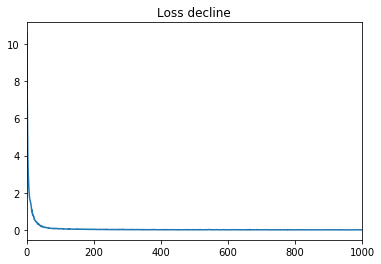

In [9]:
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    loss = []
    for i in range(iteration):
        data =[]
        for temp in range(batch_num):
            ind = np.random.randint(0,len(sn_list)-1)
            sub = sn_list[ind]
            data.append(sub)
        data = np.array(data)
        (loss_val, _) = sess.run([ae.loss, ae.train], {p_input: data})
        loss.append(loss_val)
        print('iter %d:' % (i + 1), loss_val)
    pd.Series(loss).plot(title="Loss decline")
    save_path = saver.save(sess, modlepath)
    print("Model saved in file: %s" % save_path) 

# Calculate parameters using Vn1 dataset 

In [10]:
with tf.Session() as sess:
    saver.restore(sess, modlepath) 
    print("Model restored.") 
    print('Initialized')
    
    err_vec_list = []
    for _ in range(len(vn1_list)//batch_num):
        data =[]
        for temp in range(batch_num):
            ind = np.random.randint(0,len(vn1_list)-1)
            sub = vn1_list[ind]
            data.append(sub)
        data = np.array(data)
        (input_, output_) = sess.run([ae.input_, ae.output_], {p_input: data})
        err_vec_list.append(abs(input_ - output_))
    err_vec = np.mean(np.array(err_vec_list),axis=0).reshape(batch_num,-1)
    mu = np.mean(err_vec,axis=0)
    sigma = np.cov(err_vec.T)
    print("Got parameters mu and sigma.")

INFO:tensorflow:Restoring parameters from C:/Users/Bin/Desktop/Thesis/tmp/LSTMAutoencoder_kdd99_v1.ckpt
Model restored.
Initialized
Got parameters mu and sigma.


# Calculate anomaly score, get threshold t using Vn2 and Va dataset.

In [11]:
with tf.Session() as sess:
    saver.restore(sess, modlepath) 
    print("Model restored.") 
    print('Initialized')
    
    normal_score = []
    for count in range(len(vn2_list)//batch_num):
        normal_sub = np.array(vn2_list[count*batch_num:(count+1)*batch_num]) 
        (input_n, output_n) = sess.run([ae.input_, ae.output_], {p_input: normal_sub})
        err_n = abs(input_n-output_n).reshape(-1,step_num)
        err_n = err_n.reshape(batch_num,-1)
        for batch in range(batch_num):
           temp = np.dot( (err_n[batch] - mu ).reshape(1,-1)  , sigma.T)
           s = np.dot(temp,(err_n[batch] - mu ))
           normal_score.append(s[0])
           
    abnormal_score = []
    for count in range(len(va_list)//batch_num):
        abnormal_sub = np.array(va_list[count*batch_num:(count+1)*batch_num]) 
        (input_a, output_a) = sess.run([ae.input_, ae.output_], {p_input: abnormal_sub})
        err_a = abs(input_a-output_a).reshape(-1,step_num)
        err_a = err_a.reshape(batch_num,-1)
        for batch in range(batch_num):
           temp = np.dot( (err_a[batch] - mu ).reshape(1,-1)  , sigma.T)
           s = np.dot(temp,(err_a[batch] - mu ))
           abnormal_score.append(s[0])
             

    print('Finished')

#    print("normal score ",normal_score)
#    print("abnormal score ",abnormal_score)

INFO:tensorflow:Restoring parameters from C:/Users/Bin/Desktop/Thesis/tmp/LSTMAutoencoder_kdd99_v1.ckpt
Model restored.
Initialized
Finished


In [12]:
# choose threshold
min_a = min(abnormal_score)
normal_score = np.array(normal_score)
foo = normal_score[normal_score<min_a]

threshold =( np.median(np.array(abnormal_score)) + np.median(np.array(normal_score)) )/2

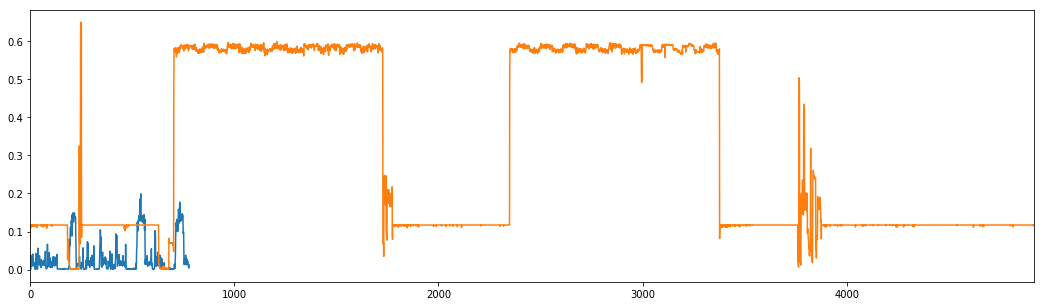

In [13]:
# anomaly score of vn2 and va dataset
pd.Series(normal_score).plot(figsize=(18,5))
pd.Series(abnormal_score).plot()

In [14]:
beta = 0.1
tp = np.array(abnormal_score)[abnormal_score>threshold].size
fp = len(abnormal_score)-tp
fn = np.array(normal_score)[normal_score>threshold].size
P = tp/(tp+fp)
R = tp/(tp+fn)
fbeta= (1+beta*beta)*P*R/(beta*beta*P+R)
fbeta

0.9717753458400584

# test

INFO:tensorflow:Restoring parameters from C:/Users/Bin/Desktop/Thesis/tmp/LSTMAutoencoder_kdd99_v1.ckpt
Model restored.
Initialized
Predict result :


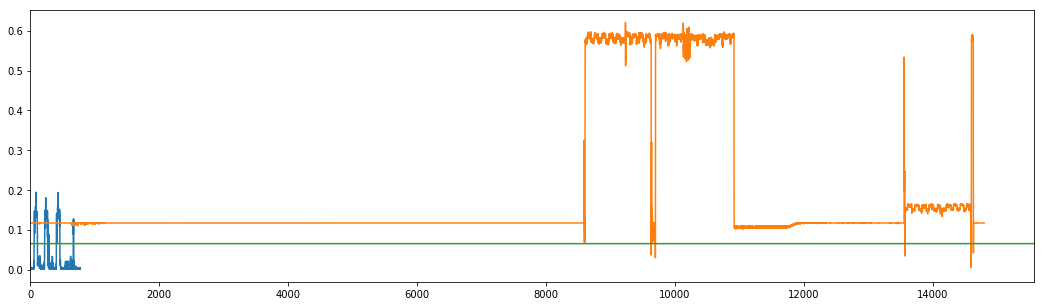

In [15]:
with tf.Session() as sess:
    saver.restore(sess, modlepath)  # decode_without_input=True, iter=5000
    print("Model restored.") 
    print('Initialized')
    
    normal_score = []
    n_in = []
    n_out = []
    a_in = []
    a_out = []
    
    for count in range(len(tn_list)//batch_num):
        normal_sub = np.array(tn_list[count*batch_num:(count+1)*batch_num]) 
        (input_n, output_n) = sess.run([ae.input_, ae.output_], {p_input: normal_sub})
        n_in.append(input_n)
        n_out.append(output_n)
        err_n = abs(input_n-output_n).reshape(-1,step_num)
        err_n = err_n.reshape(batch_num,-1)
        for batch in range(batch_num):
           temp = np.dot( (err_n[batch] - mu ).reshape(1,-1)  , sigma.T)
           s = np.dot(temp,(err_n[batch] - mu ))
           normal_score.append(s[0])
           
    abnormal_score = []
    for count in range(len(ta_list)//batch_num):
        abnormal_sub = np.array(ta_list[count*batch_num:(count+1)*batch_num]) 
        (input_a, output_a) = sess.run([ae.input_, ae.output_], {p_input: abnormal_sub})
        a_in.append(input_a)
        a_out.append(output_a)
        err_a = abs(input_a-output_a).reshape(-1,step_num)
        err_a = err_a.reshape(batch_num,-1)
        for batch in range(batch_num):
           temp = np.dot( (err_a[batch] - mu ).reshape(1,-1)  , sigma.T)
           s = np.dot(temp,(err_a[batch] - mu ))
           abnormal_score.append(s[0])
             

    print('Predict result :')

    pd.Series(normal_score).plot(label="normal_score",figsize=(18,5))
    pd.Series(abnormal_score).plot(label="abnormal_score")
    bar = threshold*np.ones(len(normal_score)+len(abnormal_score))
    pd.Series(bar).plot(label="threshold")

# Evaluation

In [16]:
beta = 0.1
tp = np.array(abnormal_score)[np.array(abnormal_score)>threshold].size
fp = len(abnormal_score)-tp
fn = np.array(normal_score)[np.array(normal_score)>threshold].size
tn = len(normal_score)- fn
P = tp/(tp+fp)
R = tp/(tp+fn)
fbeta= (1+beta*beta)*P*R/(beta*beta*P+R)
fbeta

0.998957152269816

In [17]:
print(tp,fp,tn,fn,P,R)

14786 14 621 159 0.999054054054054 0.9893609902977585
